In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from collections import Counter
from Bio import SeqIO
from Bio.Blast import NCBIXML

In [4]:
data_dir = '/content/drive/MyDrive/Biological Data'

In [5]:
domain_sequence = 'VLVLRKSNFAEALAAHKYLLVEFYAPWCGHCKALAPEYAKAAGKLKAEGSEIRLAKVDATEESDLAQQYGVRGYPTIKFFRNGDTASPKEYTAGREADDIVNWLKK'

## Part 2 - Models evaluation

A little bit of info about thioredoxin - https://en.wikipedia.org/wiki/Thioredoxin


### Task 1 - Generate predictions. Run HMM-SEARCH and PSI-BLAST with your models against SwissProt.

1.a) HMM-search

HMM-SEARCH performed using https://www.ebi.ac.uk/Tools/hmmer/search/hmmsearch

Steps to replicate: 
1. Go to the website 
2. Click 'Upload a file' and upload HMM model
3. In 'Sequence Database' choose SwissProt
4. If performing search against only human proteins: 

  In 'Restrict by Taxonomy' under 'Organism' select human (taxid: 9606)
5. Default parameters stay default - no changes
6. Submit your search

Results obtained:
1. 31 significant hits (only considering human proteins) with 0.03 threshold for e-value

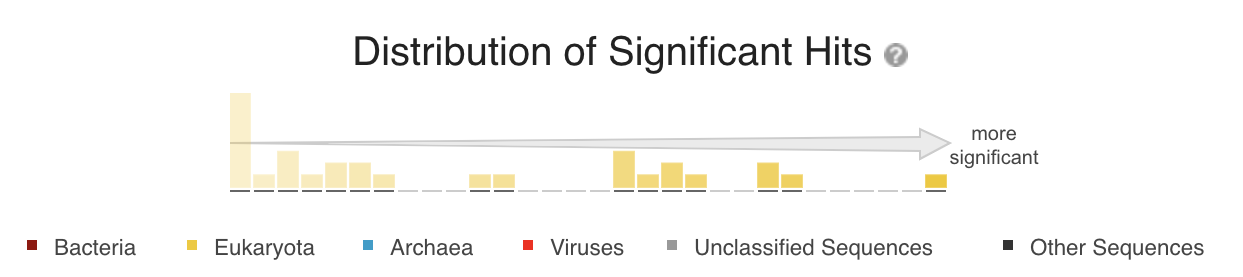

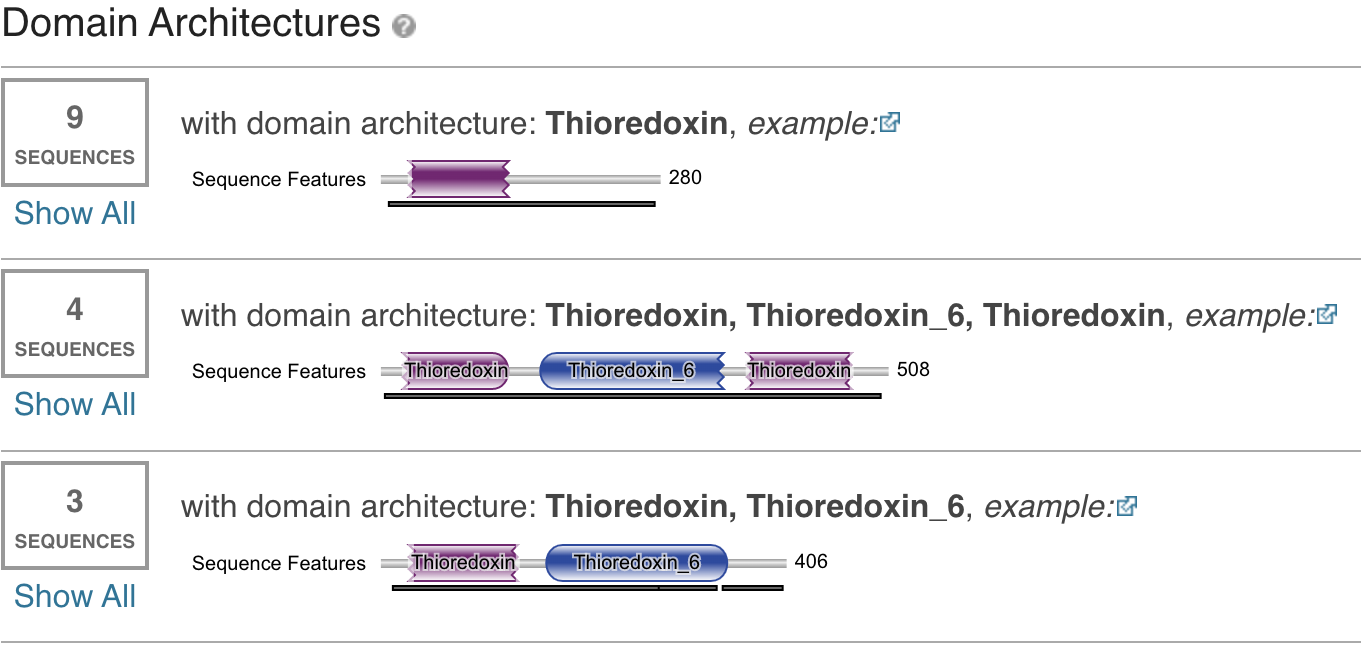
2. 552 significant hits against SwissProt





PSI-BLAST

PSI-BLAST with PSSM model against SwissProt using https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastp&PAGE_TYPE=BlastSearch&BLAST_SPEC=&LINK_LOC=blasttab&LAST_PAGE=blastx

Steps to replicate:
1. Insert initial sequence into 'Enter Query Sequence' window
2. In 'Choose Search Set' select SwissProt database and organism human (taxid: 9606)
3. 'Program Selection' Algorithm - PSI-BLAST
4. Under 'Algorithm parameters' upload PSSM model and leave other parameters default

Results obtained: 
1. Human organism - 34 significant hits with e-value threshold = 0.03
2. 500+ significant hits against SwissProt 


1.b) Collect matching positions of your models in the retrieved hits



In [6]:
hmm_hits = pd.read_csv('{}/Final_project/hmmsearch_swissprot.tsv'.format(data_dir), sep='\t')
hmm_hits.head()

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,NGLY1_CAEEL,NGLY1_CAEEL,606,refined_clustal_blast_P07237,-,925,7.700000e-182,612.1,0.0,1,...,309,925,3,606,2,606,0.92,Peptide-N(4)-(N-acetyl-beta-glucosaminyl)aspar...,NaN,0
1,PDIA4_HUMAN,PDIA4_HUMAN,645,refined_clustal_blast_P07237,-,925,1.700000e-174,587.8,7.3,1,...,11,162,1,167,1,174,0.88,Protein disulfide-isomerase A4,3idv_A,0
2,PDIA4_HUMAN,PDIA4_HUMAN,645,refined_clustal_blast_P07237,-,925,1.700000e-174,587.8,7.3,2,...,50,424,173,644,164,645,0.80,Protein disulfide-isomerase A4,3idv_A,0
3,NGLY1_CAEBR,NGLY1_CAEBR,602,refined_clustal_blast_P07237,-,925,3.300000e-174,586.8,0.4,1,...,308,924,2,602,1,602,0.93,Peptide-N(4)-(N-acetyl-beta-glucosaminyl)aspar...,NaN,0
4,PDIA4_BOVIN,PDIA4_BOVIN,643,refined_clustal_blast_P07237,-,925,9.900000e-173,581.9,9.6,1,...,11,167,1,171,1,177,0.89,Protein disulfide-isomerase A4,NaN,0


In [7]:
hmm_hits.columns

Index(['Target Name', 'Target Accession', 'Target Length', 'Query Name',
       'Query Accession', 'Query Length', 'E-value', 'Score', 'Bias',
       'Domain Index', 'Domain Count', 'Cond. E-value', 'Domain Ind. E-value',
       'Domain Bit-score', 'Domain Bias', 'Query Ali. Start', 'Query Ali. End',
       'Target Ali. Start', 'Target Ali. End', 'Target Env. Start',
       'Target Env. End', 'Acc', 'Description', 'Mapped PDB(s)',
       'Number of Identical Sequences'],
      dtype='object')

### Task 2 - Define your ground truth. Find all proteins in SwissProt annotated (and not annotated) with the assigned Pfam domain.

2.a) Collect the list of proteins matching the assigned Pfam domain. 

b) Collect matching positions of the Pfam domain in retrieved sequences.

Three ways of obtaining the list of proteins matching the assigned Pfam domain. 

1. Uniprot DB - insert pfam domain id PF00085 into the search and run search against UniProtKB. In the menu on the left of the screen select only human organism. It returns 165 results. 

2. Pfam website - browse the Pfam domain id. It returns a table which you can query. In the query insert 'homo sapiens' and run search. Returns 165 results. 

3. The last option, since the first and the second ones are UniProtKB db, is to run HMMSEARCH against SwissProt directly. In that way we get both the list of proteins and the positions of domain matches. 
- To perform this search, go to HMMSEARCH and select 'Accession search'
- Select 'PF00085' as a pfam domain and SwissProt as a database
- Select taxonomy 'human taxid 9606'
- All of the other parameters are default
- Then download .tsv file with matched hits. 

In [8]:
pfam_domain_id = 'PF00085' 

### Task 3 - Compare your model with the assigned Pfam. 

3.a) Compare at the protein level.

In [9]:
pfam_data = pd.read_csv('{}/Final_project/pfam_hmmsearch_swissprot.tsv'.format(data_dir), sep='\t')
pfam_data = pfam_data[pfam_data['E-value']<0.03]
pfam_data.head()

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Query Ali. Start,Query Ali. End,Target Ali. Start,Target Ali. End,Target Env. Start,Target Env. End,Acc,Description,Mapped PDB(s),Number of Identical Sequences
0,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,1,...,2,102,62,163,61,164,0.96,Protein disulfide-isomerase A4,3ec3_A,0
1,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,2,...,2,101,177,277,176,279,0.96,Protein disulfide-isomerase A4,3ec3_A,0
2,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,3,...,3,103,526,631,524,631,0.94,Protein disulfide-isomerase A4,3ec3_A,0
3,PDIA4_CAEEL,PDIA4_CAEEL,618,Thioredoxin,-,103,2.300000e-96,321.4,0.1,1,...,2,102,38,135,37,136,0.98,Probable protein disulfide-isomerase A4,NaN,0
4,PDIA4_CAEEL,PDIA4_CAEEL,618,Thioredoxin,-,103,2.300000e-96,321.4,0.1,2,...,2,102,149,250,148,251,0.97,Probable protein disulfide-isomerase A4,NaN,0


In [10]:
pfam_data.columns

Index(['Target Name', 'Target Accession', 'Target Length', 'Query Name',
       'Query Accession', 'Query Length', 'E-value', 'Score', 'Bias',
       'Domain Index', 'Domain Count', 'Cond. E-value', 'Domain Ind. E-value',
       'Domain Bit-score', 'Domain Bias', 'Query Ali. Start', 'Query Ali. End',
       'Target Ali. Start', 'Target Ali. End', 'Target Env. Start',
       'Target Env. End', 'Acc', 'Description', 'Mapped PDB(s)',
       'Number of Identical Sequences'],
      dtype='object')

In [11]:
' '.join(list(pfam_data['Target Accession']))

'PDIA4_RAT PDIA4_RAT PDIA4_RAT PDIA4_CAEEL PDIA4_CAEEL PDIA4_CAEEL PDIA4_MOUSE PDIA4_MOUSE PDIA4_MOUSE PDIA4_BOVIN PDIA4_BOVIN PDIA4_BOVIN PDIA4_HUMAN PDIA4_HUMAN PDIA4_HUMAN DJC10_HUMAN DJC10_HUMAN DJC10_HUMAN DJC10_HUMAN DJC10_MOUSE DJC10_MOUSE DJC10_MOUSE DJC10_MOUSE DJC10_PONAB DJC10_PONAB DJC10_PONAB DJC10_PONAB DJC10_XENLA DJC10_XENLA DJC10_XENLA DJC10_XENLA DJC10_RAT DJC10_RAT DJC10_RAT DJC10_RAT TXND5_MOUSE TXND5_MOUSE TXND5_MOUSE TXND5_HUMAN TXND5_HUMAN TXND5_HUMAN TXND5_DROME TXND5_DROME TXND5_DROME PDIA5_HUMAN PDIA5_HUMAN PDIA5_HUMAN PDIA5_RAT PDIA5_RAT PDIA5_RAT PDIA5_MOUSE PDIA5_MOUSE PDIA5_MOUSE PDI21_ORYSJ PDI21_ORYSJ PDI1_SCHPO PDI1_SCHPO PDI22_ORYSJ PDI22_ORYSJ PDIA6_MEDSA PDIA6_MEDSA PDI21_ARATH PDI21_ARATH PDIA3_CHLAE PDIA3_CHLAE PDIA3_HUMAN PDIA3_HUMAN PDIA3_PONAB PDIA3_PONAB PDIA3_BOVIN PDIA3_BOVIN PDIA3_MOUSE PDIA3_MOUSE PDIA3_RAT PDIA3_RAT PDIA5_BOVIN PDIA5_BOVIN PDIA5_BOVIN PDIA3_CHICK PDIA3_CHICK PDI_ARTBC PDI_ARTBC PDI_ARTBC PDI_ARTBC PDIA6_MESAU PDIA6_MESAU P

In [12]:
pfam_set = set(pfam_data[pfam_data['E-value']<0.03]['Target Accession'])
len(pfam_set)

616

In [13]:
# HMMSEARCH
data = []
for i in range(1, 11):
  file_name = f'{data_dir}/Final_project/models_stats/{i}/hmm_hits_{i}.tsv'
  df = pd.read_csv(file_name, sep="\t")
  pred = set(df.loc[df['E-value'] < 0.03]['Target Accession'])
  data.append([f'hmm_hits_{i}.tsv', len(pfam_set.intersection(pred)), len(pred - pfam_set), len(pfam_set - pred)])
df = pd.DataFrame(data, columns=['file', 'TP', 'FP', 'FN'])
df

,file,TP,FP,FN
0,hmm_hits_1.tsv,528,24,88
1,hmm_hits_2.tsv,558,13,58
2,hmm_hits_3.tsv,594,12,22
3,hmm_hits_4.tsv,467,0,149
4,hmm_hits_5.tsv,538,20,78
5,hmm_hits_6.tsv,548,21,68
6,hmm_hits_7.tsv,530,11,86
7,hmm_hits_8.tsv,522,18,94
8,hmm_hits_9.tsv,542,15,74
9,hmm_hits_10.tsv,535,13,81


NOTE: Not all of the mappings were available

Expected - 616
\ Received - 611

In [14]:
df_mapping = pd.read_csv('{}/Final_project/mapping.tsv'.format(data_dir), sep='\t')
df_mapping.head()

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
0,PDIA4_RAT,P38659,reviewed,PDIA4_RAT,Protein disulfide-isomerase A4 (EC 5.3.4.1) (C...,Pdia4 Cabp2 Erp70,Rattus norvegicus (Rat),643
1,PDIA4_CAEEL,P34329,reviewed,PDIA4_CAEEL,Probable protein disulfide-isomerase A4 (EC 5....,C14B9.2,Caenorhabditis elegans,618
2,PDIA4_MOUSE,P08003,reviewed,PDIA4_MOUSE,Protein disulfide-isomerase A4 (EC 5.3.4.1) (E...,Pdia4 Cai Erp72,Mus musculus (Mouse),638
3,PDIA4_BOVIN,Q29RV1,reviewed,PDIA4_BOVIN,Protein disulfide-isomerase A4 (EC 5.3.4.1),PDIA4,Bos taurus (Bovine),643
4,PDIA4_HUMAN,P13667,reviewed,PDIA4_HUMAN,Protein disulfide-isomerase A4 (EC 5.3.4.1) (E...,PDIA4 ERP70 ERP72,Homo sapiens (Human),645


In [15]:
df_gt_blast = pd.merge(pfam_data, df_mapping, left_on='Target Accession', right_on=['From'], how='inner')
df_gt_blast.head()

,Target Name,Target Accession,Target Length,Query Name,Query Accession,Query Length,E-value,Score,Bias,Domain Index,...,Mapped PDB(s),Number of Identical Sequences,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length
0,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,1,...,3ec3_A,0,PDIA4_RAT,P38659,reviewed,PDIA4_RAT,Protein disulfide-isomerase A4 (EC 5.3.4.1) (C...,Pdia4 Cabp2 Erp70,Rattus norvegicus (Rat),643
1,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,2,...,3ec3_A,0,PDIA4_RAT,P38659,reviewed,PDIA4_RAT,Protein disulfide-isomerase A4 (EC 5.3.4.1) (C...,Pdia4 Cabp2 Erp70,Rattus norvegicus (Rat),643
2,PDIA4_RAT,PDIA4_RAT,643,Thioredoxin,-,103,1.400000e-96,322.1,0.2,3,...,3ec3_A,0,PDIA4_RAT,P38659,reviewed,PDIA4_RAT,Protein disulfide-isomerase A4 (EC 5.3.4.1) (C...,Pdia4 Cabp2 Erp70,Rattus norvegicus (Rat),643
3,PDIA4_CAEEL,PDIA4_CAEEL,618,Thioredoxin,-,103,2.300000e-96,321.4,0.1,1,...,NaN,0,PDIA4_CAEEL,P34329,reviewed,PDIA4_CAEEL,Probable protein disulfide-isomerase A4 (EC 5....,C14B9.2,Caenorhabditis elegans,618
4,PDIA4_CAEEL,PDIA4_CAEEL,618,Thioredoxin,-,103,2.300000e-96,321.4,0.1,2,...,NaN,0,PDIA4_CAEEL,P34329,reviewed,PDIA4_CAEEL,Probable protein disulfide-isomerase A4 (EC 5....,C14B9.2,Caenorhabditis elegans,618


In [16]:
pfam_set = set(df_gt_blast[df_gt_blast['E-value']<0.03]['Entry'])
len(pfam_set)

611

In [17]:
# PSI-BLAST
data = []
for i in range(1, 11):
  file_name = f'{data_dir}/Final_project/models_stats/{i}/blast_hits_{i}.csv'
  df = pd.read_csv(file_name, names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
  df[['acc', 'version']] = df['subject'].str.split('.', 1, expand=True)
  pred = set(df.loc[df['evalue'] < 0.03]['acc'])
  data.append([f'blast_hits_{i}.csv', len(pfam_set.intersection(pred)), len(pred - pfam_set), len(pfam_set - pred)])
df = pd.DataFrame(data, columns=['file', 'TP', 'FP', 'FN'])
df

,file,TP,FP,FN
0,blast_hits_1.csv,491,9,120
1,blast_hits_2.csv,492,8,119
2,blast_hits_3.csv,490,10,121
3,blast_hits_4.csv,370,4,241
4,blast_hits_5.csv,492,8,119
5,blast_hits_6.csv,491,9,120
6,blast_hits_7.csv,490,10,121
7,blast_hits_8.csv,491,9,120
8,blast_hits_9.csv,492,8,119
9,blast_hits_10.csv,490,10,121


In [18]:
def calculate_statistics(TP, FP, FN, TN=None):
  """
  Will calculate the balanced accuracy and MCC only if True Negatives are present
  """
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f_score = 2 * (precision * recall) / (precision + recall)
  # If True Negatives are given
  if TN:
    balanced_accuracy = 0.5 * (TP/(TP+FP) + TN/(TN+FN))
    mcc = ((TP*TN) - (FP*FN))/ np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    return round(precision, 2), round(recall, 2), round(f_score, 2), round(balanced_accuracy, 2), round(mcc, 2)

  return round(precision, 2), round(recall, 2), round(f_score, 2)

3.b) Comparison at the residue level.

The domain predicted positions are Target Env. Start and Target Env. End in the hits tables. BUT need to verify with prof. 

About the envelopes (page 25) - http://eddylab.org/software/hmmer3/3.1b2/Userguide.pdf

In [19]:
# Data preparation
def prepare_pfam_hmm_merge(pfam_data, file_path):
  df = pd.read_csv(file_path, sep="\t")
  hmm_pred = df.loc[df['E-value'] < 0.03]

  # gt = pfam_data[pfam_data['E-value']<0.03]
  # gt_psiblast = df_gt_blast

  # df = pd.read_csv('{}/Final_project/{}'.format(data_dir, 'psiblast_swissprot.csv'), names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
  # df[['acc', 'version']] = df['subject'].str.split('.', 1, expand=True)
  # psiblast_pred = df.loc[df['evalue'] < 0.03]['acc']

  hmm_general = pd.merge(pfam_data, hmm_pred, left_on=['Target Name', 'Domain Index'], right_on=['Target Name', 'Domain Index'], how='outer')
  return hmm_general

In [20]:
def xml_to_df(file_name):
  names = []
  # Read files with alignments  
  tree = ET.parse(file_name)
  root = tree.getroot()
  attributes_list = []
  # Iterating over the children
  for child in root:
    # if child.tag == 'data':
    for hits in child:
      if hits.attrib.get('nregions'):
        nregions = hits.attrib['nregions']
        # print(hits.attrib)
        # Iterating to get alignments sequences
        i = 0
        for val in hits:
          if val.tag == 'domains':
            attributes = val.attrib
            attributes['domain_ind'] = i+1
            attributes_list.append(attributes)
            i += 1
        if i + 1 > 10:
          print(hits.attrib['alisqname'])
          print(i+1)

  df_alignments = pd.DataFrame.from_dict(attributes_list)
  return df_alignments

In [34]:
def compare_domain_position_match(hmm_general, alignments_dfs):
  TP, TN, FP, FN = 0, 0, 0, 0

  for row in range(len(hmm_general)):
    # Pfam is empty
    if pd.isnull(hmm_general.loc[row]['Target Accession_x']):
      start_y = hmm_general.loc[row]['Target Ali. Start_y']
      end_y = hmm_general.loc[row]['Target Ali. End_y']
      pred_domain_len = end_y - start_y + 1

      target_length = hmm_general.loc[row]['Target Length_y']
      # Our model predicted a domain, but Pfam did not 
      FP += pred_domain_len
      TN += target_length - pred_domain_len

    # HMM is empty
    elif pd.isnull(hmm_general.loc[row]['Target Accession_y']):
      start_x = hmm_general.loc[row]['Target Ali. Start_x']
      end_x = hmm_general.loc[row]['Target Ali. End_x']
      pred_domain_len = end_x - start_x + 1

      target_length = hmm_general.loc[row]['Target Length_x']
      # Our model did not predict a domain, but Pfam did 
      FN += pred_domain_len
      TN += target_length - pred_domain_len

    # Both are present
    else:
      label = hmm_general.loc[row]['Target Name']
      hmm_idx = hmm_general.loc[row]['Domain Index']
      # Extract aligments 
      hmm_ali = alignments_dfs[alignments_dfs['alisqname']==label]
      hmm_ali = list(hmm_ali[hmm_ali['domain_ind']==hmm_idx]['aliaseq_y'])[0]

      pfam_ali = alignments_dfs[alignments_dfs['alisqname']==label]
      pfam_ali = list(pfam_ali[pfam_ali['domain_ind']==hmm_idx]['aliaseq_x'])[0]

      # Count the number of gaps for hmm and pfam
      pfam_gaps = dict(Counter(list(pfam_ali))).get('-', 0)
      hmm_gaps = dict(Counter(list(hmm_ali))).get('-', 0)

      start_x = hmm_general.loc[row]['Target Ali. Start_x']
      end_x = hmm_general.loc[row]['Target Ali. End_x']
      start_y = hmm_general.loc[row]['Target Ali. Start_y']
      end_y = hmm_general.loc[row]['Target Ali. End_y']

      target_length = hmm_general.loc[row]['Target Length_x']

      start = max(start_x, start_y)
      end = min(end_x, end_y)

      if end > start:
        TP += end - start + 1
        if start_x < start_y:
          FN += start_y - start_x + 1
        elif start_y < start_x:
          FP += start_x - start_y + 1
        if end_x < end_y:
          FP = end_y - end_x + 1
        elif end_y < end_x:
          FN += end_x - end_y + 1

        TN += target_length - (max(end_x, end_y) - min(start_x, start_y) + 1) 
        FN += hmm_gaps

    # max_count = hmm_general.loc[row]['Domain Count_y']
    # if hmm_general.loc[row]['Domain Count_x'] > hmm_general.loc[row]['Domain Count_y']:
    #   max_count = hmm_general.loc[row]['Domain Count_x']
  return TP, TN, FP, FN

In [22]:
def print_stats_results(precision, recall, f_score, balanced_accuracy=None, mcc=None):
  output = f'Precision: {precision}\nRecall: {recall}\nF-score: {f_score}\n'
  if balanced_accuracy and mcc:
    output += f'Balanced accuracy: {balanced_accuracy}\nMCC: {mcc}'
  print(output)

In [23]:
def parse_blast_xml(file_path):
    # Parse the XML output
  # https://www.biostars.org/p/82514/
  with open(file_path) as f:
    blast_records = NCBIXML.parse(f)
    data = []

    # Iterate PSIBLAST rounds (here just one since it is a simple BLAST)
    for blast_record in blast_records:
        query_id = blast_record.query

        # Iterate queries (here just one)
        for i, alignment in enumerate(blast_record.alignments):
            subject_id = alignment.title.split('|')[1].split('.')[0]
            length = int(str(alignment).split('= ')[-1])
            # print(length)
            # Iterate pairwise alignments
            counter = 1
            start_positions = {}
            for hsp in alignment.hsps:
              # if subject_id == 'P38659':
              #   print(hsp.sbjct_start)
              start_positions[counter] = hsp.sbjct_start
              counter += 1

            # Sort starting positions to get correct domain index 
            sorted_start_pos = dict(sorted(start_positions.items(), key=lambda x:x[1]))
            # print(sorted_start_pos)
            
            counter = 1
            for hsp in alignment.hsps:
              ind = list(sorted_start_pos).index(counter) + 1
              # if subject_id == 'P38659':
                # print(ind)
                # print(sorted_start_pos)
              data.append((query_id,
                              subject_id,
                              blast_record.query_length,
                              hsp.query,
                              hsp.match,
                              hsp.sbjct,
                              hsp.query_start,
                              hsp.query_end,
                              hsp.sbjct_start,
                              hsp.sbjct_end,
                              hsp.identities,
                              hsp.positives,
                              hsp.gaps,
                              hsp.expect,
                              hsp.score, 
                              ind, 
                              length))
              counter += 1
              
              # Skip duplicated subjects
              # break
                  
    df = pd.DataFrame(data, columns=["query_id", "subject_id", "query_len",
                                    "query_seq", "match_seq", "subject_seq",
                                  "query_start", "query_end", "subject_start", "subject_end", 
                                  "identity", "positive", "gaps", "eval", "bit_score", "domain_ind", 
                                  "seq_length"])
    return df

In [24]:
blast_df_test = parse_blast_xml(f'{data_dir}/Final_project/models_stats/1/blast_ali_1.xml')
# blast_df_test[blast_df_test['subject_id']=='P38659']

In [25]:
# Data preparation
def prepare_pfam_blast_merge(df_gt_blast, file_path_csv, file_path_xml):
  df = pd.read_csv(file_path_csv, names=['query', 'subject', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start', 's_end', 'evalue', 'bit_score', 'q_coverage'])
  df[['acc', 'version']] = df['subject'].str.split('.', 1, expand=True)
  pred = df.loc[df['evalue'] < 0.03]

  blast_df_test = parse_blast_xml(file_path_xml)
  first_merge = pd.merge(blast_df_test, pred, left_on=['subject_id', 'subject_start', 'subject_end'], right_on=['acc', 's_start', 's_end'], how='inner')
  second_merge = pd.merge(df_gt_blast, first_merge, left_on=['Entry', 'Domain Index'], right_on=['subject_id', 'domain_ind'], how='outer')

  return second_merge

In [33]:
def compare_domain_position_match_blast(blast_gt_data):
  TP, TN, FP, FN = 0, 0, 0, 0

  for row in range(len(blast_gt_data)):
    #Pfam is empty
    if pd.isnull(blast_gt_data.loc[row]['Target Accession']):
      start_y = blast_gt_data.loc[row]['subject_start']
      end_y = blast_gt_data.loc[row]['subject_end']
      pred_domain_len = end_y - start_y + 1

      # print(blast_gt_data.loc[row]['subject_id'])
      # print(len(blast_gt_data.loc[row]['subject_seq']))
      # print(len(blast_gt_data.loc[row]['']))
      target_length = blast_gt_data.loc[row]['seq_length']
      # Our model predicted a domain, but Pfam did not 
      FP += pred_domain_len
      TN += target_length - pred_domain_len

    # PSI-BLAST is empty
    elif pd.isnull(blast_gt_data.loc[row]['subject_id']):
      start_x = blast_gt_data.loc[row]['Target Ali. Start']
      end_x = blast_gt_data.loc[row]['Target Ali. End']
      pred_domain_len = end_x - start_x + 1

      target_length = blast_gt_data.loc[row]['Target Length']
      # Our model did not predict a domain, but Pfam did 
      FN += pred_domain_len
      TN += target_length - pred_domain_len

    # Both are present
    else:
      label = blast_gt_data.loc[row]['Target Name']
      hmm_idx = blast_gt_data.loc[row]['Domain Index']
      # Extract gaps 
      blast_gaps = blast_gt_data.loc[row]['gaps']

      start_x = blast_gt_data.loc[row]['Target Ali. Start']
      end_x = blast_gt_data.loc[row]['Target Ali. End']
      start_y = blast_gt_data.loc[row]['subject_start']
      end_y = blast_gt_data.loc[row]['subject_end']

      target_length = blast_gt_data.loc[row]['Target Length']

      start = max(start_x, start_y)
      end = min(end_x, end_y)

      if end > start:
        TP += end - start + 1
        if start_x < start_y:
          FN += start_y - start_x + 1
        elif start_y < start_x:
          FP += start_x - start_y + 1
        if end_x < end_y:
          FP = end_y - end_x + 1
        elif end_y < end_x:
          FN += end_x - end_y + 1

        TN += target_length - (max(end_x, end_y) - min(start_x, start_y) + 1) 
        FN += blast_gaps

    # max_count = hmm_general.loc[row]['Domain Count_y']
    # if hmm_general.loc[row]['Domain Count_x'] > hmm_general.loc[row]['Domain Count_y']:
    #   max_count = hmm_general.loc[row]['Domain Count_x']
  return TP, TN, FP, FN

In [35]:
for i in range(1, 11):
  file_name_csv = f'{data_dir}/Final_project/models_stats/{i}/blast_hits_{i}.csv'
  file_name_xml = f'{data_dir}/Final_project/models_stats/{i}/blast_ali_{i}.xml'
  blast_gt_data = prepare_pfam_blast_merge(df_gt_blast, file_name_csv, file_name_xml)

  TP, FP, FN, TN = compare_domain_position_match_blast(blast_gt_data)
  precision, recall, f_score, balanced_accuracy, mcc = calculate_statistics(TP, FP, FN, TN)
  print(f"PSI-BLAST MODEL {i}\n")
  print_stats_results(precision, recall, f_score, balanced_accuracy, mcc)
  print('\n\n')

PSI-BLAST MODEL 1

Precision: 0.24
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 2

Precision: 0.23
Recall: 0.98
F-score: 0.37
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 3

Precision: 0.23
Recall: 0.98
F-score: 0.37
Balanced accuracy: 0.57
MCC: 0.08



PSI-BLAST MODEL 4

Precision: 0.05
Recall: 0.99
F-score: 0.1
Balanced accuracy: 0.52
MCC: 0.1



PSI-BLAST MODEL 5

Precision: 0.24
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 6

Precision: 0.23
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 7

Precision: 0.24
Recall: 0.97
F-score: 0.38
Balanced accuracy: 0.57
MCC: 0.08



PSI-BLAST MODEL 8

Precision: 0.24
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 9

Precision: 0.24
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09



PSI-BLAST MODEL 10

Precision: 0.24
Recall: 0.98
F-score: 0.38
Balanced accuracy: 0.58
MCC: 0.09





In [36]:
for i in range(1, 11):
  file_name = f'{data_dir}/Final_project/models_stats/{i}/hmm_hits_{i}.tsv'
  hmm_general = prepare_pfam_hmm_merge(pfam_data, file_name)
  # Get alignment dataframes
  hmm_align_df = xml_to_df(f'{data_dir}/Final_project/models_stats/{i}/hmm_ali_{i}.xml')
  pfam_align_df = xml_to_df(f'{data_dir}/Final_project/pfam_seq.xml')

  alignments_dfs = pd.merge(pfam_align_df, hmm_align_df, left_on=['alisqname', 'domain_ind'], right_on=['alisqname', 'domain_ind'], how='outer')
  TP, FP, FN, TN = compare_domain_position_match(hmm_general, alignments_dfs)
  precision, recall, f_score, balanced_accuracy, mcc = calculate_statistics(TP, FP, FN, TN)
  print(f"HMM MODEL {i}\n")
  print_stats_results(precision, recall, f_score, balanced_accuracy, mcc)
  print('\n\n')

HMM MODEL 1

Precision: 0.29
Recall: 0.89
F-score: 0.44
Balanced accuracy: 0.55
MCC: 0.07



HMM MODEL 2

Precision: 0.3
Recall: 0.92
F-score: 0.45
Balanced accuracy: 0.54
MCC: 0.06



HMM MODEL 3

Precision: 0.25
Recall: 0.96
F-score: 0.4
Balanced accuracy: 0.47
MCC: -0.03



HMM MODEL 4

Precision: 0.06
Recall: 1.0
F-score: 0.11
Balanced accuracy: 0.53
MCC: 0.12



HMM MODEL 5

Precision: 0.3
Recall: 0.87
F-score: 0.45
Balanced accuracy: 0.51
MCC: 0.02



HMM MODEL 6

Precision: 0.32
Recall: 0.88
F-score: 0.47
Balanced accuracy: 0.52
MCC: 0.03



HMM MODEL 7

Precision: 0.29
Recall: 0.93
F-score: 0.44
Balanced accuracy: 0.56
MCC: 0.08



HMM MODEL 8

Precision: 0.28
Recall: 0.92
F-score: 0.43
Balanced accuracy: 0.57
MCC: 0.11



HMM MODEL 9

Precision: 0.28
Recall: 0.87
F-score: 0.43
Balanced accuracy: 0.49
MCC: -0.01



HMM MODEL 10

Precision: 0.29
Recall: 0.9
F-score: 0.44
Balanced accuracy: 0.54
MCC: 0.06



